<a href="https://colab.research.google.com/github/lala991204/DL-self-study/blob/master/1_dentist_%EB%B0%98%EA%B0%80%EC%9A%B4%EB%8B%A8%EB%B9%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import json
import shutil
import glob
from tqdm import tqdm

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/aihub/golf/source"     # image 위치
annot = "/content/drive/MyDrive/real_dentist/json"     # json 위치
img_path = '/content/drive/MyDrive/real_dentist'

In [ ]:
output = glob.glob('/content/drive/MyDrive/real_dentist/*.json')
for file_path in output:
  h = []
  with open(file_path, 'r') as file:
    h.append(json.load(file))
  pt = []
  for i in range(len(h[0]['shapes'])):
    pt.append(h[0]['shapes'][i]['points'])
  coor = []
  for comp in pt:
    obj = Polygon(comp)
    obj1 = obj.to_bounding_box()
    a = tuple(map(int, tuple(obj1[0])))
    b = tuple(map(int, tuple(obj1[1])))
    coor.append([[a[0], a[1]], [b[0], b[1]]])
  for i in range(len(h[0]['shapes'])):
    h[0]['shapes'][i]['points'] = coor[i]
    h[0]['shapes'][i]['shape_type'] = 'rectangle'
  with open('/content/drive/MyDrive/real_dentist/json/data{}.json'.format(k[36:48]), 'w') as fp:
    json.dump(h[0], fp)

In [ ]:
def get_iou(bb1, bb2):
    iou = 3
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top) # 교집합

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # 교집합 / 합집합
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
gtvalues=[]

for e,i in tqdm(enumerate(os.listdir(annot))):
    filename = i[4:-5]+".jpg"

    image = cv2.imread(os.path.join(img_path,filename))
    with open(os.path.join(annot,i), 'r', encoding="UTF-8") as f:
        json_data = json.load(f)

    h = json_data
    pt = []
    for i in range(len(h['shapes'])):
      pt.append(h['shapes'][i]['points'])


   # 여러 개 디텍트 할 시에
    for row in pt:
        x1 = int(row[0][0])
        y1 = int(row[0][1])
        x2 = int(row[1][0])
        y2 = int(row[1][1])

        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
print(X_new.shape)
print(y_new.shape)

(622, 224, 224, 3)
(622,)


In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X = vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
vggmodel.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model_final = Model(vggmodel.input,predictions)

In [ ]:
# Optimizer 설정
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

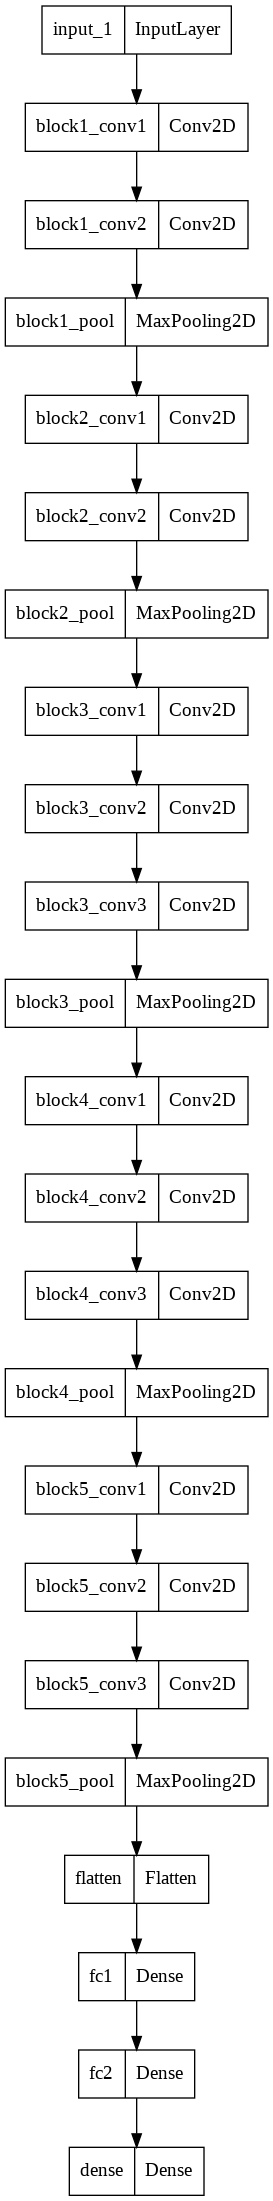

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_final, to_file='vgg.png')

In [ ]:
y_new

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(559, 224, 224, 3)
(63, 224, 224, 3)
(559, 2)
(63, 2)


In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.9076 
Epoch 1: val_loss improved from inf to 0.27469, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 263s 26s/step - loss: 0.6903 - accuracy: 0.9076 - val_loss: 0.2747 - val_accuracy: 0.9048
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9375 
Epoch 2: val_loss improved from 0.27469 to 0.19948, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 266s 27s/step - loss: 0.2131 - accuracy: 0.9375 - val_loss: 0.1995 - val_accuracy: 0.9206
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9406 
Epoch 3: val_loss improved from 0.19948 to 0.05417, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 251s 25s/step - loss: 0.1809 - accuracy: 0.9406 - val_loss: 0.0542 - val_accuracy: 0.9683
Epoch 4/10
10/10 [==============================] - ETA: 0s - 

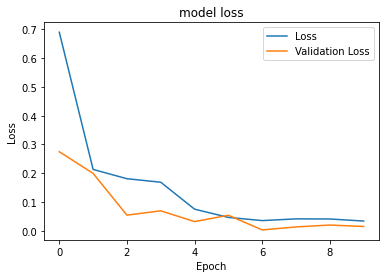

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
out= model_final.predict(img)
out.shape

(1, 2)

In [ ]:
out

array([[0.79348475, 0.20651528]], dtype=float32)

1332it [00:09, 140.38it/s]


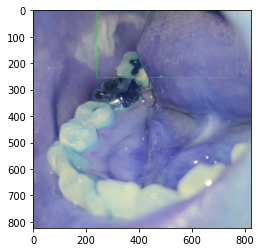

1332it [00:09, 140.95it/s]


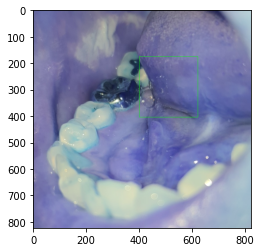

1332it [00:09, 141.14it/s]


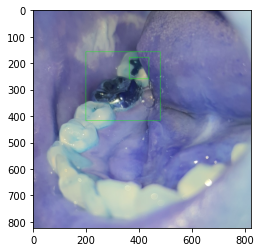

1332it [00:09, 142.45it/s]


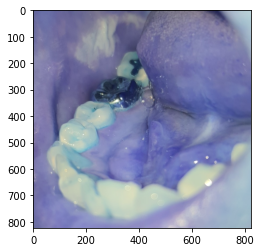

1332it [00:10, 122.28it/s]


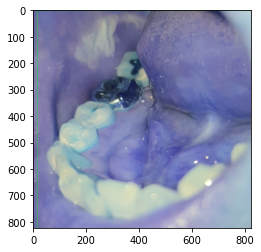

1332it [00:09, 141.15it/s]


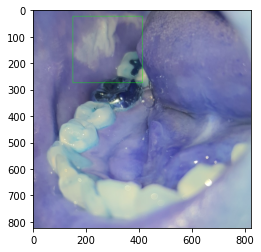

1332it [00:09, 141.53it/s]


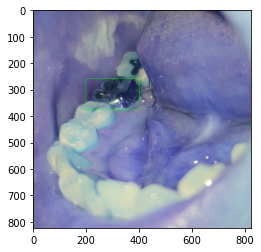

1332it [00:09, 141.31it/s]


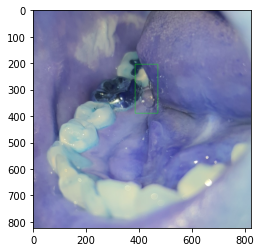

1332it [00:09, 142.27it/s]


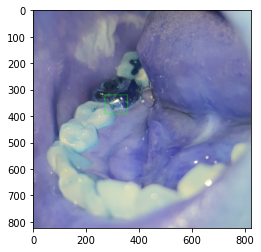

1332it [00:09, 140.23it/s]


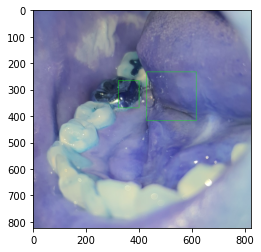

1332it [00:10, 132.97it/s]


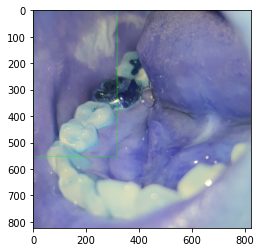

1332it [00:09, 139.92it/s]


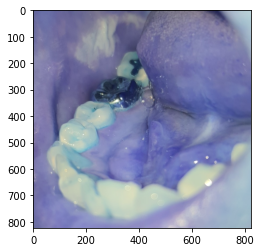

1332it [00:09, 140.30it/s]


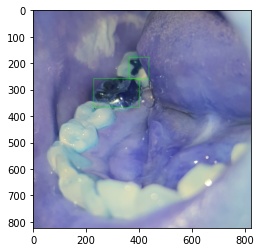

1332it [00:09, 140.98it/s]


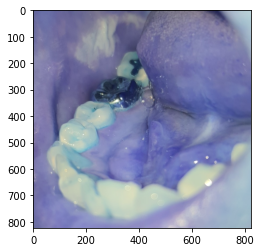

1332it [00:09, 140.07it/s]


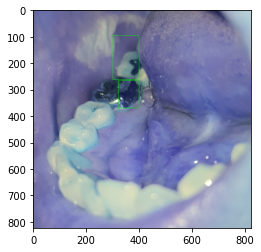

1332it [00:09, 139.60it/s]


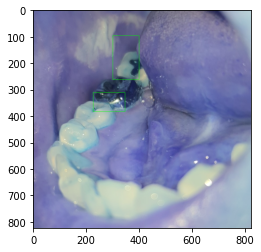

1332it [00:09, 140.79it/s]


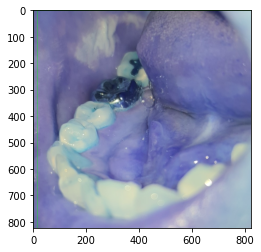

10it [00:06,  1.57it/s]

In [ ]:
for j in range(20):
  img = cv2.imread('/content/drive/MyDrive/real_dentist/001_00107_10.jpg')
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = img.copy()
  for e,result in tqdm(enumerate(ssresults)):
      if e < 15:
          x,y,w,h = result
          timage = imout[y:y+h,x:x+w]
          resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
          img = np.expand_dims(resized, axis=0)
          out= model_final.predict(img)
          if out[0][0] > 0.7:
              cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  plt.figure()
  plt.imshow(imout)
  plt.show()